In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from surprise import SVD
from surprise import Dataset, Reader, accuracy

In [2]:
ratings = pd.read_csv("ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
df = ratings.drop("timestamp", axis=1)
df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [4]:
trainset, testset = train_test_split(df, test_size=.2)
print("Train size: ", trainset.shape)
print("Test size: ", testset.shape)

Train size:  (80668, 3)
Test size:  (20168, 3)


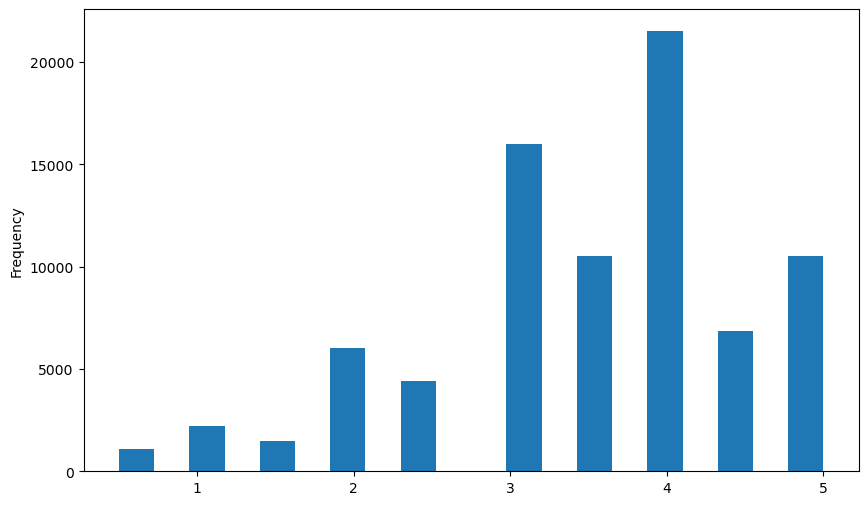

In [5]:
plt.figure(figsize = (10, 6))
trainset.rating.plot.hist(bins = 20)
plt.show()

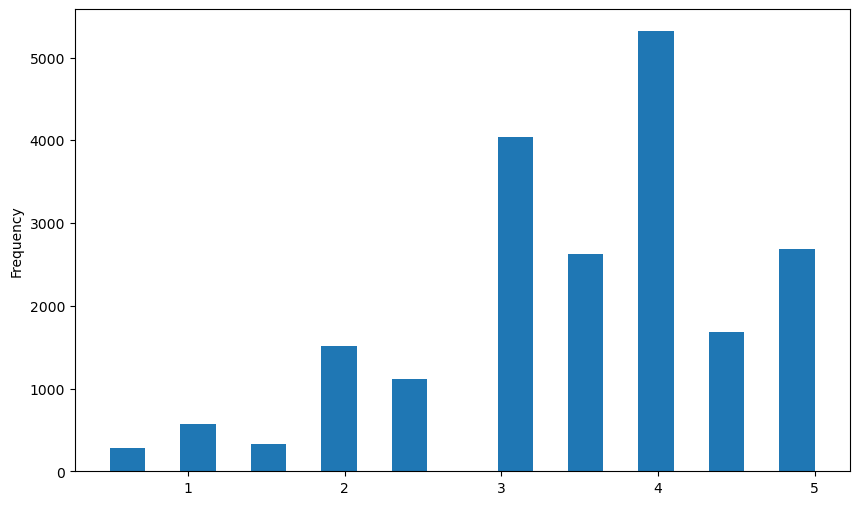

In [6]:
plt.figure(figsize = (10, 6))
testset.rating.plot.hist(bins = 20)
plt.show()

In [7]:
reader = Reader(rating_scale = (1, 5))
data_train = Dataset.load_from_df(trainset, reader)
data_test = Dataset.load_from_df(testset, reader)

In [8]:
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

In [9]:
mean = data_train.global_mean
print('Train rating', mean)

mean = data_test.global_mean
print('Test rating', mean)

Train rating 3.501599147121535
Test rating 3.5013883379611266


In [10]:
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

In [63]:
algo = SVD(n_factors=50, n_epochs=20, verbose=True)

In [64]:
algo.fit(data_train)


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [65]:
train_pred = algo.test(data_trainset)
accuracy.rmse(train_pred)

RMSE: 0.7167


0.716679897952924

In [66]:
test_pred = algo.test(data_testset)
accuracy.rmse(test_pred)

RMSE: 0.8692


0.8692346629572315